## Ingesting and Exploring Data

In [1]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

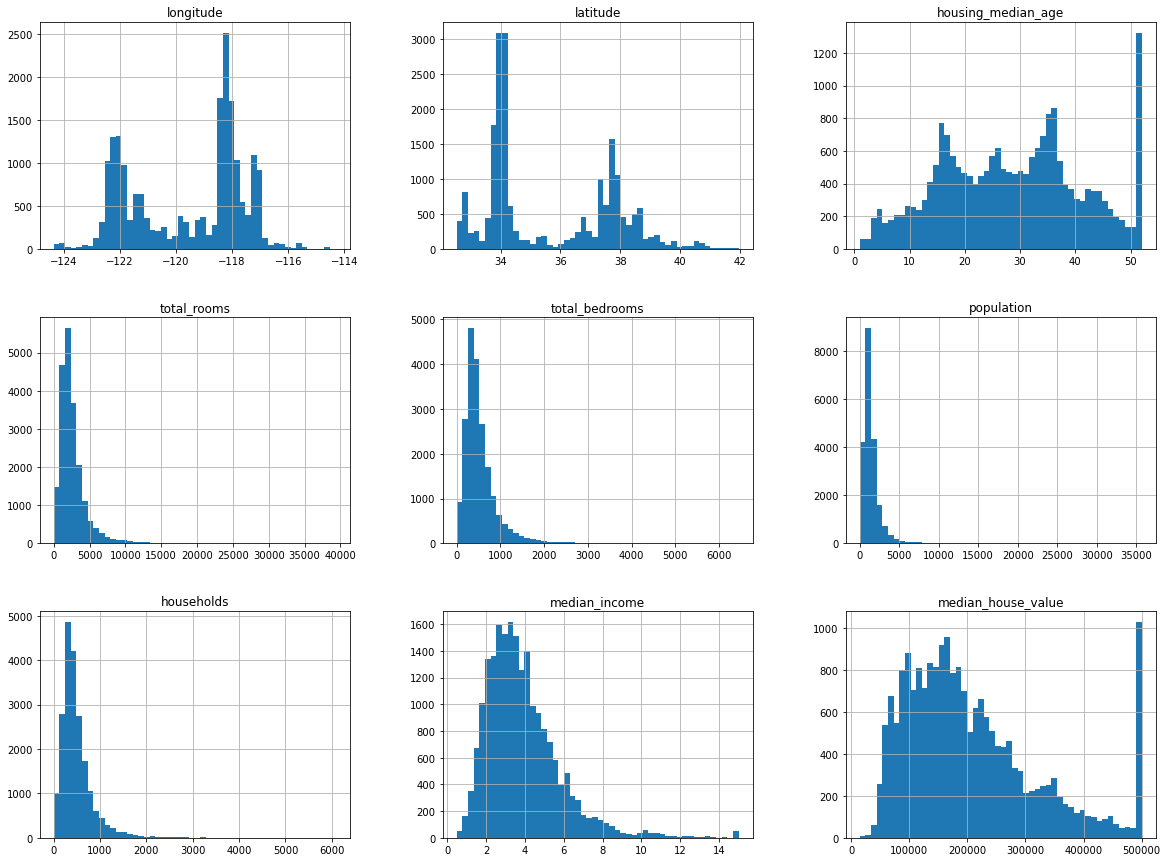

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [7]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [9]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import numpy as np

In [10]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

<AxesSubplot:>

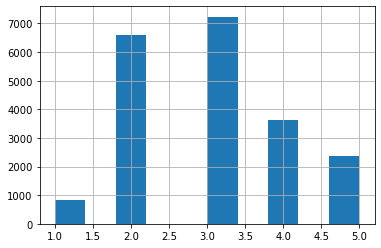

In [11]:
housing['income_cat'] = pd.cut(housing["median_income"],
                            bins=[0.,1.5,3.0,4.5,6.0, np.inf],
                            labels=[1,2,3,4,5])

housing["income_cat"].hist()

In [12]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [13]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

<function matplotlib.pyplot.legend(*args, **kwargs)>

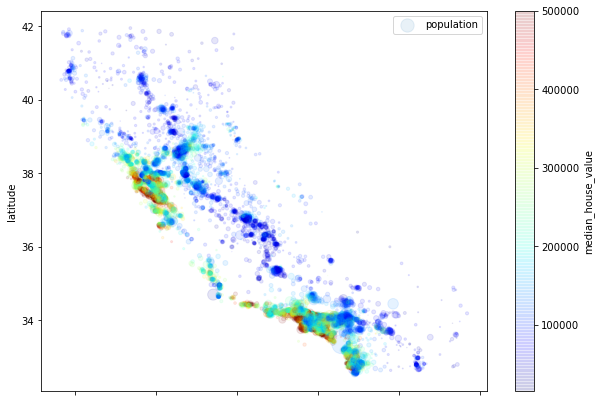

In [14]:
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=.1,
            s=housing["population"]/100, label="population", figsize=(10,7),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend

<Preparing Data for Algorithm/>

## **PREPARING DATA FOR ALGORITHM**

In [15]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [16]:
num_housing = housing.drop("ocean_proximity", axis=1)

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                        ('std_scaler', StandardScaler()),
                        ])

num_attribs = list(num_housing)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

 # **Training and Evaluating on Training Set**

In [21]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

parameter_grid = [
    {'kernel':["linear"], 'C':[10,100,1000,10000,50000,100000] },
    {'kernel':["rbf"], 'C':[10,100,1000,10000,50000,100000], 
    'gamma': [.005,.01,.05,.1,.5,1,3]}
]

svm_reg = SVR()
param_search = GridSearchCV(svm_reg, parameter_grid, scoring="neg_mean_squared_error", verbose=2)
param_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ................................C=10, kernel=linear; total time=   6.3s
[CV] END ................................C=10, kernel=linear; total time=   6.4s
[CV] END ................................C=10, kernel=linear; total time=   6.4s
[CV] END ................................C=10, kernel=linear; total time=   6.6s
[CV] END ................................C=10, kernel=linear; total time=   6.7s
[CV] END ...............................C=100, kernel=linear; total time=   6.7s
[CV] END ...............................C=100, kernel=linear; total time=   6.6s
[CV] END ...............................C=100, kernel=linear; total time=   6.5s
[CV] END ...............................C=100, kernel=linear; total time=   6.7s
[CV] END ...............................C=100, kernel=linear; total time=   6.5s
[CV] END ..............................C=1000, kernel=linear; total time=   6.8s
[CV] END ..............................C=1000, 

[CV] END ....................C=1000, gamma=0.005, kernel=rbf; total time=  12.3s
[CV] END ....................C=1000, gamma=0.005, kernel=rbf; total time=  12.0s
[CV] END ....................C=1000, gamma=0.005, kernel=rbf; total time=  12.1s
[CV] END ....................C=1000, gamma=0.005, kernel=rbf; total time=  12.2s
[CV] END .....................C=1000, gamma=0.01, kernel=rbf; total time=  11.8s
[CV] END .....................C=1000, gamma=0.01, kernel=rbf; total time=  12.1s
[CV] END .....................C=1000, gamma=0.01, kernel=rbf; total time=  11.9s
[CV] END .....................C=1000, gamma=0.01, kernel=rbf; total time=  11.7s
[CV] END .....................C=1000, gamma=0.01, kernel=rbf; total time=  11.8s
[CV] END .....................C=1000, gamma=0.05, kernel=rbf; total time=  11.5s
[CV] END .....................C=1000, gamma=0.05, kernel=rbf; total time=  11.9s
[CV] END .....................C=1000, gamma=0.05, kernel=rbf; total time=  12.0s
[CV] END ...................

[CV] END .......................C=50000, gamma=3, kernel=rbf; total time=  25.2s
[CV] END .......................C=50000, gamma=3, kernel=rbf; total time=  29.5s
[CV] END ..................C=100000, gamma=0.005, kernel=rbf; total time=  13.4s
[CV] END ..................C=100000, gamma=0.005, kernel=rbf; total time=  12.4s
[CV] END ..................C=100000, gamma=0.005, kernel=rbf; total time=  13.6s
[CV] END ..................C=100000, gamma=0.005, kernel=rbf; total time=  12.5s
[CV] END ..................C=100000, gamma=0.005, kernel=rbf; total time=  12.2s
[CV] END ...................C=100000, gamma=0.01, kernel=rbf; total time=  12.5s
[CV] END ...................C=100000, gamma=0.01, kernel=rbf; total time=  12.4s
[CV] END ...................C=100000, gamma=0.01, kernel=rbf; total time=  12.5s
[CV] END ...................C=100000, gamma=0.01, kernel=rbf; total time=  12.9s
[CV] END ...................C=100000, gamma=0.01, kernel=rbf; total time=  12.7s
[CV] END ...................

GridSearchCV(estimator=SVR(),
             param_grid=[{'C': [10, 100, 1000, 10000, 50000, 100000],
                          'kernel': ['linear']},
                         {'C': [10, 100, 1000, 10000, 50000, 100000],
                          'gamma': [0.005, 0.01, 0.05, 0.1, 0.5, 1, 3],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [22]:
import joblib

my_model = param_search.best_estimator_
my_model
joblib.dump(my_model, "my_svm_model.pkl")

['my_svm_model.pkl']

In [30]:
np.sqrt(-param_search.best_score_)

55122.79755221637